In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


#### Deterministic discretization of the SIR model using Eulers method

In [52]:
beta = 0.5     # infection rate
gamma = 0.1    # recovery rate
mu = 0.01      # death rate
k = 0.9        # non-linear contact rate
dt = 1         # time step (days)
T = 160        # total simulation time

In [53]:
# Initial values
N = 10_000
S0, I0, R0, D0 = N-10, 10, 0, 0

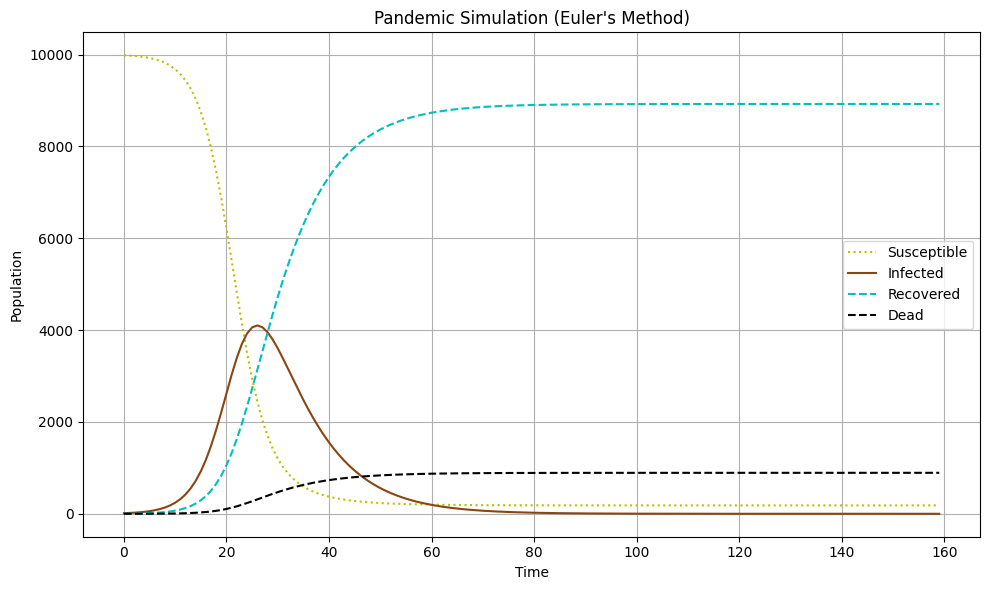

In [54]:
# Eulers model
def euler_step(S, I, R, D, beta, gamma, mu, k, dt, N):
    ln_term = np.log(1 + beta * I / N)
    dS = -k * S * ln_term
    dI = -dS - (gamma + mu) * I
    dR = gamma * I
    dD = mu * I

    S = S + dt * dS
    I = I + dt * dI
    R = R + dt * dR
    D = D + dt * dD
    
    return S, I, R, D

# Simulation
S, I, R, D = S0, I0, R0, D0
time = np.arange(0, T, dt)
S_list, I_list, R_list, D_list = [], [], [], []
for t in time:
    S, I, R, D = euler_step(S, I, R, D, beta, gamma, mu, k, dt,N)
    S_list.append(S)
    I_list.append(I)
    R_list.append(R)
    D_list.append(D)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, S_list, 'y:', label='Susceptible')
plt.plot(time, I_list, 'saddlebrown', label='Infected')
plt.plot(time, R_list, 'c--', label='Recovered')
plt.plot(time, D_list, 'k--', label='Dead')
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Pandemic Simulation (Euler's Method)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Stochastic discretization of SIR model

In [74]:
beta = 0.00218    # infection rate
gamma = 0.4    # recovery rate
mu = 0.01      # death rate
k = 10        # non-linear contact rate
#dt = 0.0001         # time step (days)
T = 160        # total simulation time

# Initial values
N = 1_000
S0, I0, R0, D0 = N-10, 10, 0, 0


In [ ]:
def simulate_stochastic_sir_discrete(
    S0: int,
    I0: int,
    R0: int,
    D0: int,
    beta: float,
    k: float,
    gamma: float,
    mu: float,
    T: int,
    random_seed: int = None
):
    """
    Simulate the stochastic discrete‐time SIR(+D) model over T steps.

    Parameters
    ----------
    S0, I0, R0, D0 : int
        Initial counts of Susceptible, Infected, Recovered, Dead.
    beta : float
        Transmission rate.
    k : float
        Overdispersion parameter.
    gamma : float
        Recovery rate.
    mu : float
        Death rate.
    T : int
        Number of time‐steps to simulate.
    random_seed : int, optional
        Seed for reproducibility.

    Returns
    -------
    S, I, R, D : ndarray of shape (T+1,)
        Time series of counts.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # pre‐allocate arrays
    S = np.zeros(T+1, dtype=int)
    I = np.zeros(T+1, dtype=int)
    R = np.zeros(T+1, dtype=int)
    D = np.zeros(T+1, dtype=int)

    # set initials
    S[0], I[0], R[0], D[0] = S0, I0, R0, D0

    # constant binomial probabilities for recoveries and deaths
    p_r = 1.0 - np.exp(-gamma)
    p_d = 1.0 - np.exp(-mu)

    for t in range(T):
        s_t, i_t = S[t], I[t]

        # 1) recoveries
        r_t = np.random.binomial(i_t, p_r)

        # 2) deaths among those still infected
        survivors = i_t - r_t
        d_t = np.random.binomial(survivors, p_d)

        # 3) new infections from susceptibles
        #    p_inf = 1 - (k / (k + beta * i_t))**k
        p_inf = 1.0 - (k / (k + beta * i_t))**k if i_t > 0 else 0.0
        new_inf_t = np.random.binomial(s_t, p_inf)

        # update
        S[t+1] = s_t - new_inf_t
        I[t+1] = i_t + new_inf_t - r_t - d_t
        R[t+1] = R[t] + r_t
        D[t+1] = D[t] + d_t

    return S, I, R, D



# example parameter set
S0, I0, R0, D0 = 990, 10, 0, 0
#beta = 0.3
#k = 2.0
#gamma = 1/7    # avg. infectious period = 7 days
#mu = 1      # daily death rate
T = 160

S, I, R, D = simulate_stochastic_sir_discrete(
    S0, I0, R0, D0, beta, k, gamma, mu, T, random_seed=42
)

# simply print final sizes
print(f"After {T} days: S={S[-1]}, I={I[-1]}, R={R[-1]}, D={D[-1]}")


After 160 days: S=44, I=0, R=600, D=356


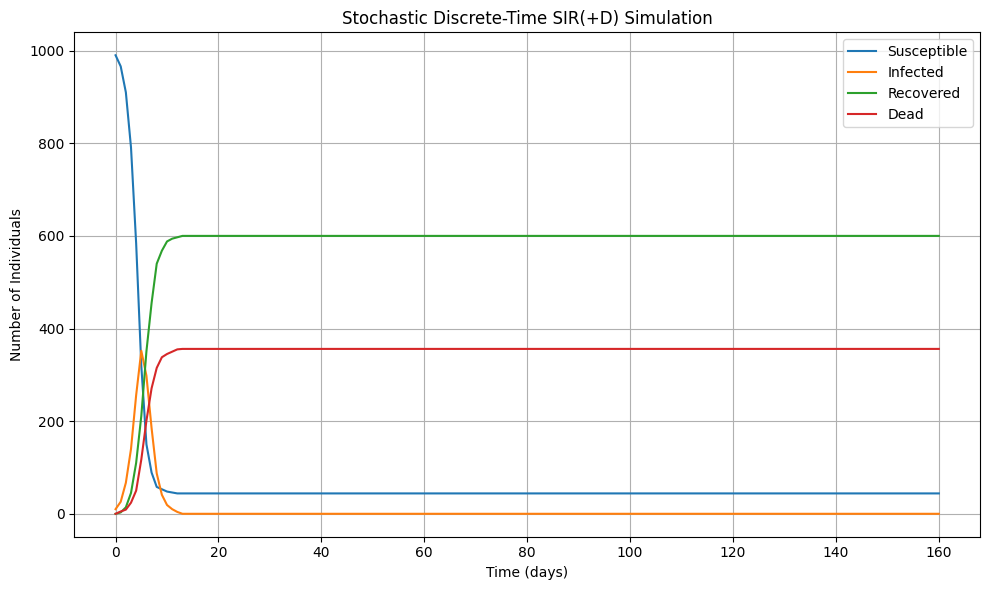

In [71]:
# Plotting
t = np.arange(T+1)

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, D, label='Dead')
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('Stochastic Discrete-Time SIR(+D) Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
import numpy as np

def simulate_stochastic_sir_discrete(
    S0: int,
    I0: int,
    R0: int,
    D0: int,
    beta: float,
    k: float,
    gamma: float,
    mu: float,
    lambda_: float,
    T: int,
    random_seed: int = None
):
    """
    Simulate the stochastic discrete‐time SIRS(+D) model over T steps,
    allowing recovered individuals to lose immunity at rate lambda_.

    Parameters
    ----------
    S0, I0, R0, D0 : int
        Initial counts of Susceptible, Infected, Recovered, Dead.
    beta : float
        Transmission rate.
    k : float
        Overdispersion parameter.
    gamma : float
        Recovery rate.
    mu : float
        Death rate.
    lambda_ : float
        Rate at which recovered lose immunity and return to S.
    T : int
        Number of time‐steps to simulate.
    random_seed : int, optional
        Seed for reproducibility.

    Returns
    -------
    S, I, R, D : ndarray of shape (T+1,)
        Time series of counts.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # pre‐allocate
    S = np.zeros(T+1, dtype=int)
    I = np.zeros(T+1, dtype=int)
    R = np.zeros(T+1, dtype=int)
    D = np.zeros(T+1, dtype=int)

    # initials
    S[0], I[0], R[0], D[0] = S0, I0, R0, D0

    # constant binomial probs
    p_r = 1.0 - np.exp(-gamma)
    p_d = 1.0 - np.exp(-mu)
    p_l = 1.0 - np.exp(-lambda_)   # waning immunity

    for t in range(T):
        s_t, i_t, r_t0 = S[t], I[t], R[t]

        # 1) recoveries
        r_t = np.random.binomial(i_t, p_r)

        # 2) deaths among those still infected
        survivors = i_t - r_t
        d_t = np.random.binomial(survivors, p_d)

        # 3) new infections from the *original* susceptibles only
        p_inf = 1.0 - (k / (k + beta * i_t))**k if i_t > 0 else 0.0
        new_inf_t = np.random.binomial(s_t, p_inf)
        s_after_inf = s_t - new_inf_t

        # 4) waning immunity: recovered -> susceptible
        #    allow the entire recovered pool (old + new) to lose immunity
        recov_pool = R[t] + r_t
        l_t = np.random.binomial(recov_pool, p_l)
        r_postlam = recov_pool - l_t

        # write‐back
        S[t+1] = s_after_inf + l_t
        I[t+1] = i_t + new_inf_t - r_t - d_t
        R[t+1] = r_postlam
        D[t+1] = D[t] + d_t

    return S, I, R, D

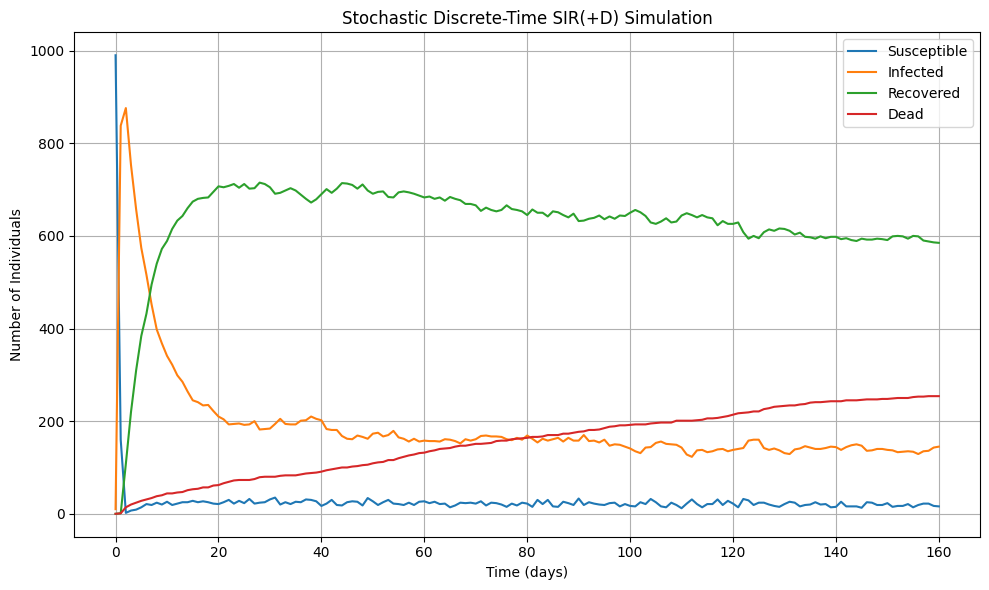

In [79]:
S, I, R, D = simulate_stochastic_sir_discrete(
    990, 10, 0, 0,
    beta=0.3, k=2.0,
    gamma=1/7, mu=0.01,
    lambda_=1/30,   # avg immunity duration = 30 days
    T=160,
    random_seed=42
)

# Plotting
t = np.arange(T+1)

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, D, label='Dead')
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('Stochastic Discrete-Time SIR(+D) Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()